In [1]:
module_path = 'https://tfhub.dev/deepmind/biggan-deep-256/1' 

In [2]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

import os
import io
import IPython.display
import numpy as np
import PIL.Image
from scipy.stats import truncnorm
import tensorflow_hub as hub

2023-07-25 05:20:13.234481: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
tf.reset_default_graph()
print('Loading BigGAN module from:', module_path)
module = hub.Module(module_path)
inputs = {k: tf.placeholder(v.dtype, v.get_shape().as_list(), k)
          for k, v in module.get_input_info_dict().items()}
output = module(inputs)

print()
print('Inputs:\n', '\n'.join(
    '  {}: {}'.format(*kv) for kv in inputs.items()))
print()
print('Output:', output)

Loading BigGAN module from: https://tfhub.dev/deepmind/biggan-deep-256/1


2023-07-25 05:21:43.366834: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: UNKNOWN ERROR (34)


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore



Inputs:
   y: Tensor("y:0", shape=(?, 1000), dtype=float32)
  truncation: Tensor("truncation:0", shape=(), dtype=float32)
  z: Tensor("z:0", shape=(?, 128), dtype=float32)

Output: Tensor("module_apply_default/G_trunc_output:0", shape=(?, 256, 256, 3), dtype=float32)


In [4]:
input_z = inputs['z']
input_y = inputs['y']
input_trunc = inputs['truncation']

dim_z = input_z.shape.as_list()[1]
vocab_size = input_y.shape.as_list()[1]

def truncated_z_sample(batch_size, truncation=1., seed=None):
  state = None if seed is None else np.random.RandomState(seed)
  values = truncnorm.rvs(-2, 2, size=(batch_size, dim_z), random_state=state)
  return truncation * values

def one_hot(index, vocab_size=vocab_size):
  index = np.asarray(index)
  if len(index.shape) == 0:
    index = np.asarray([index])
  assert len(index.shape) == 1
  num = index.shape[0]
  output = np.zeros((num, vocab_size), dtype=np.float32)
  output[np.arange(num), index] = 1
  return output

def one_hot_if_needed(label, vocab_size=vocab_size):
  label = np.asarray(label)
  if len(label.shape) <= 1:
    label = one_hot(label, vocab_size)
  assert len(label.shape) == 2
  return label

def sample(sess, noise, label, truncation=1., batch_size=8,
           vocab_size=vocab_size):
  noise = np.asarray(noise)
  label = np.asarray(label)
  num = noise.shape[0]
  if len(label.shape) == 0:
    label = np.asarray([label] * num)
  if label.shape[0] != num:
    raise ValueError('Got # noise samples ({}) != # label samples ({})'
                     .format(noise.shape[0], label.shape[0]))
  label = one_hot_if_needed(label, vocab_size)
  ims = []
  for batch_start in range(0, num, batch_size):
    s = slice(batch_start, min(num, batch_start + batch_size))
    feed_dict = {input_z: noise[s], input_y: label[s], input_trunc: truncation}
    ims.append(sess.run(output, feed_dict=feed_dict))
  ims = np.concatenate(ims, axis=0)
  assert ims.shape[0] == num
  ims = np.clip(((ims + 1) / 2.0) * 256, 0, 255)
  ims = np.uint8(ims)
  return ims

def interpolate(A, B, num_interps):
  if A.shape != B.shape:
    raise ValueError('A and B must have the same shape to interpolate.')
  alphas = np.linspace(0, 1, num_interps)
  return np.array([(1-a)*A + a*B for a in alphas])

def imgrid(imarray, cols=5, pad=1):
  if imarray.dtype != np.uint8:
    raise ValueError('imgrid input imarray must be uint8')
  pad = int(pad)
  assert pad >= 0
  cols = int(cols)
  assert cols >= 1
  N, H, W, C = imarray.shape
  rows = N // cols + int(N % cols != 0)
  batch_pad = rows * cols - N
  assert batch_pad >= 0
  post_pad = [batch_pad, pad, pad, 0]
  pad_arg = [[0, p] for p in post_pad]
  imarray = np.pad(imarray, pad_arg, 'constant', constant_values=255)
  H += pad
  W += pad
  grid = (imarray
          .reshape(rows, cols, H, W, C)
          .transpose(0, 2, 1, 3, 4)
          .reshape(rows*H, cols*W, C))
  if pad:
    grid = grid[:-pad, :-pad]
  return grid

def imshow(a, format='png', jpeg_fallback=True):
  a = np.asarray(a, dtype=np.uint8)
  data = io.BytesIO()
  PIL.Image.fromarray(a).save(data, format)
  im_data = data.getvalue()
  try:
    disp = IPython.display.display(IPython.display.Image(im_data))
  except IOError:
    if jpeg_fallback and format != 'jpeg':
      print(('Warning: image was too large to display in format "{}"; '
             'trying jpeg instead.').format(format))
      return imshow(a, format='jpeg')
    else:
      raise
  return disp

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.applications.resnet50 import preprocess_input
from PIL import Image

# 데이터셋 디렉토리 경로
image_dir = "/path/to/your/image/dataset/"
caption_file = "/path/to/your/caption/file.txt"

# 이미지 로드 및 전처리 함수
def load_and_preprocess_image(image_path):
    img = Image.open(image_path)
    img = img.resize((256, 256))  # BigGAN의 입력 크기에 맞게 리사이징
    img_array = np.array(img)
    img_array = preprocess_input(img_array)  # ResNet50의 전처리 함수 적용
    return img_array

# 텍스트 로드 및 전처리 함수
def load_and_preprocess_text(caption_file):
    with open(caption_file, "r") as f:
        captions = f.readlines()

    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(captions)
    sequences = tokenizer.texts_to_sequences(captions)
    padded_sequences = pad_sequences(sequences, padding='post')
    vocab_size = len(tokenizer.word_index) + 1  # 패딩을 위한 0을 포함한 단어 개수
    return padded_sequences, vocab_size

# 이미지 데이터 전처리
image_paths = [...]  # 이미지 파일 경로 리스트로 대체해주세요.
images = [load_and_preprocess_image(image_path) for image_path in image_paths]
images = np.array(images)

# 텍스트 데이터 전처리
captions, vocab_size = load_and_preprocess_text(caption_file)

# 이미지와 텍스트 데이터셋을 사용하여 GAN 모델 학습을 진행하면 됩니다.
# 이는 GAN 모델과 데이터로드 등에 따라 구체적인 구현 방법이 달라지므로
# 여기서는 학습 단계의 구체적인 코드를 제공하지 않습니다.

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Reshape, Conv2D, BatchNormalization, LeakyReLU, Flatten
from tensorflow.keras.optimizers import Adam

# BigGAN-Deep 생성자 모델 정의
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(Dense(256, input_shape=(100,)))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization())
    model.add(Dense(7*7*256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization())
    model.add(Reshape((7, 7, 256)))
    model.add(Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization())
    model.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization())
    model.add(Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', activation='tanh'))
    return model

# BigGAN-Deep 판별자 모델 정의
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(1))
    return model

# 데이터 로드 등의 전처리 작업 생략

# BigGAN-Deep 생성자와 판별자 모델 생성
generator = make_generator_model()
discriminator = make_discriminator_model()

# 생성자와 판별자를 결합하여 GAN 모델 생성
gan = tf.keras.Sequential([generator, discriminator])

# GAN 모델 학습을 위한 컴파일 설정
gan.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))

# GAN 모델 학습
gan.fit(train_images, epochs=100, batch_size=128)

# 텍스트를 입력으로 이미지 생성
latent_vector = np.random.randn(1, 100)  # 잠재 벡터 생성
generated_image = generator.predict(latent_vector)  # 이미지 생성

# 필요한 라이브러리 및 클래스 가져오기

In [6]:
# set all global behaviors to TensorFlow 1.x 
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import os
import io
import IPython.display
import numpy as np
import PIL.Image
from scipy.stats import truncnorm
import tensorflow_hub as hub 

# TensorFlow 허브에서 256×256 생성기 모듈 로드 TensorFlow hub

In [7]:
module_path = 'https://tfhub.dev/deepmind/biggan-deep-256/1'
tf.reset_default_graph()
print('Loading BigGAN module from:', module_path)
module = hub.Module(module_path)
inputs = {k: tf.placeholder(v.dtype, v.get_shape().as_list(), k)
          for k, v in module.get_input_info_dict().items()}
output = module(inputs) 

Loading BigGAN module from: https://tfhub.dev/deepmind/biggan-deep-256/1
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


# 원-핫 인코딩 레이블, 샘플링 및 이미지 표시를 위한 도우미 함수

In [8]:
input_z = inputs['z']
input_y = inputs['y']
input_trunc = inputs['truncation']
dim_z = input_z.shape.as_list()[1]
vocab_size = input_y.shape.as_list()[1]

def truncated_z_sample(batch_size, truncation=1., seed=None):
  state = None if seed is None else np.random.RandomState(seed)
  values = truncnorm.rvs(-2, 2, size=(batch_size, dim_z), random_state=state)
  return truncation * values

def one_hot(index, vocab_size=vocab_size):
  index = np.asarray(index)
  if len(index.shape) == 0:
    index = np.asarray([index])
  assert len(index.shape) == 1
  num = index.shape[0]
  output = np.zeros((num, vocab_size), dtype=np.float32)
  output[np.arange(num), index] = 1
  return output

def one_hot_if_needed(label, vocab_size=vocab_size):
  label = np.asarray(label)
  if len(label.shape) <= 1:
    label = one_hot(label, vocab_size)
  assert len(label.shape) == 2
  return label

def sample(sess, noise, label, truncation=1., batch_size=8,
           vocab_size=vocab_size):
  noise = np.asarray(noise)
  label = np.asarray(label)
  num = noise.shape[0]
  if len(label.shape) == 0:
    label = np.asarray([label] * num)
  label = one_hot_if_needed(label, vocab_size)
  ims = []
  for batch_start in range(0, num, batch_size):
    s = slice(batch_start, min(num, batch_start + batch_size))
    feed_dict = {input_z: noise[s], input_y: label[s], input_trunc: truncation}
    ims.append(sess.run(output, feed_dict=feed_dict))
  ims = np.concatenate(ims, axis=0)
  assert ims.shape[0] == num
  ims = np.clip(((ims + 1) / 2.0) * 256, 0, 255)
  ims = np.uint8(ims)
  return ims

def imgrid(imarray, cols=5, pad=1):
  pad = int(pad)
  assert pad >= 0
  cols = int(cols)
  assert cols >= 1
  N, H, W, C = imarray.shape
  rows = N // cols + int(N % cols != 0)
  batch_pad = rows * cols - N
  assert batch_pad >= 0
  post_pad = [batch_pad, pad, pad, 0]
  pad_arg = [[0, p] for p in post_pad]
  imarray = np.pad(imarray, pad_arg, 'constant', constant_values=255)
  H += pad
  W += pad
  grid = (imarray
          .reshape(rows, cols, H, W, C)
          .transpose(0, 2, 1, 3, 4)
          .reshape(rows*H, cols*W, C))
  if pad:
    grid = grid[:-pad, :-pad]
  return grid

def imshow(a, format='png', jpeg_fallback=True):
  a = np.asarray(a, dtype=np.uint8)
  data = io.BytesIO()
  PIL.Image.fromarray(a).save(data, format)
  im_data = data.getvalue()
  try:
    disp = IPython.display.display(IPython.display.Image(im_data))
  except IOError:
    if jpeg_fallback and format != 'jpeg':
      print(('Warning: image was too large to display in format "{}"; '
             'trying jpeg instead.').format(format))
      return imshow(a, format='jpeg')
    else:
      raise
  return disp 

# TensorFlow 세션을 만들고 변수를 초기화하고 BigGAN을 사용하여 일부 이미지를 생성

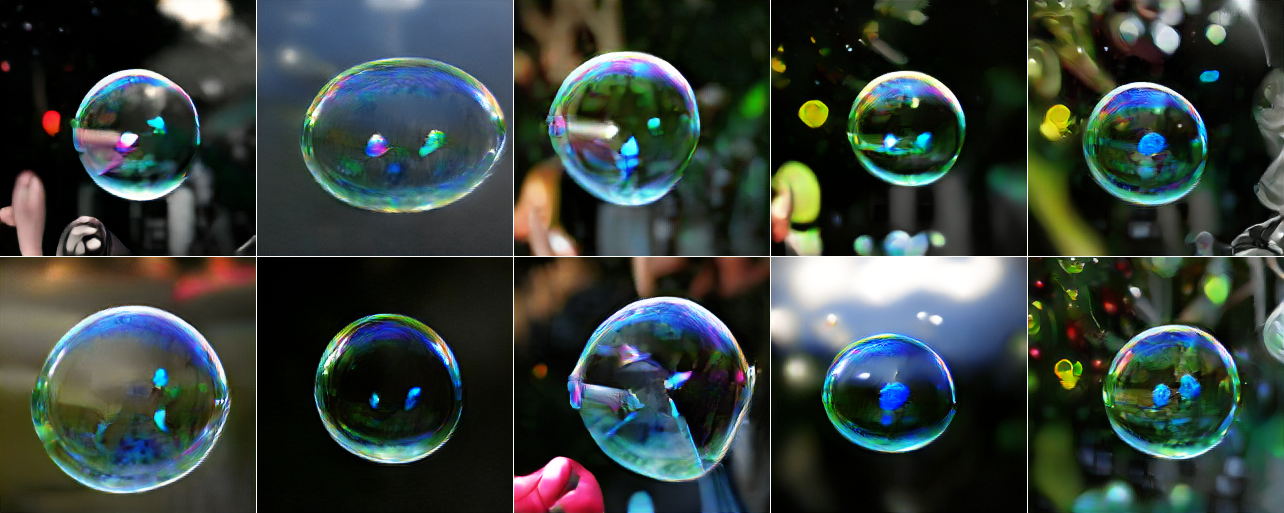

In [10]:
# create TensorFlow session and initialize variables
initializer = tf.global_variables_initializer()
sess = tf.Session()
sess.run(initializer)

# set noise seed, num of images, truncation and category to be sampled
num_samples = 10 
truncation = 0.5 
noise_seed = 0 
category = "971) bubble" 

z = truncated_z_sample(num_samples, truncation, noise_seed)
y = int(category.split(')')[0])
ims = sample(sess, z, y, truncation=truncation)
imshow(imgrid(ims, cols=min(num_samples, 5))) 

# 데이터셋 준비
# 폴더 구조 예시

- dataset
    - cats
        - cat_image1.jpg
        - cat_image2.jpg
        - ...
    - dogs
        - dog_image1.jpg
        - dog_image2.jpg
        - ...
    - cars
        - car_image1.jpg
        - car_image2.jpg
        - ...
    - airplanes
        - airplane_image1.jpg
        - airplane_image2.jpg
        - ...
        
# Label 데이터 예시 (One-Hot-Encoding)

-'Cat'는 원핫인코딩으로 [1, 0, 0, 0]

-'Dog'는 원핫인코딩으로 [0, 1, 0, 0]

-'Car'는 원핫인코딩으로 [0, 0, 1, 0]

-'Airplane'는 원핫인코딩으로 [0, 0, 0, 1]

In [ ]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

data_dir = 'path/to/your/dataset'  # 데이터셋 폴더 경로
output_dir = 'path/to/save/resized_images'  # 조정된 이미지를 저장할 폴더 경로
target_size = (256, 256)  # BigGAN은 256x256 크기의 이미지를 사용하므로 크기 조정

# 데이터셋 폴더 내 이미지 파일들을 리스트로 가져오기
image_files = [os.path.join(data_dir, file) for file in os.listdir(data_dir) if file.endswith('.jpg')]

# 이미지 크기 조정하여 저장하기
for img_file in image_files:
    img = load_img(img_file, target_size=target_size)  # 이미지 로드 및 크기 조정
    img_array = img_to_array(img)
    output_path = os.path.join(output_dir, os.path.basename(img_file))
    img.save(output_path)  # 조정된 이미지 저장